In [2]:
# ## 1. Import Libraries and Load Data

# %%
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

# Set up plotting style
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

# %%
# Load the data
df = pd.read_csv('../data/togo-dapaong_qc.csv')  # Adjust path if needed

# Display basic info
print("Dataset Shape:", df.shape)
print("\nFirst 5 rows:")
df.head()

Dataset Shape: (525600, 19)

First 5 rows:


,Timestamp,GHI,DNI,DHI,ModA,ModB,Tamb,RH,WS,WSgust,WSstdev,WD,WDstdev,BP,Cleaning,Precipitation,TModA,TModB,Comments
0,2021-10-25 00:01,-1.3,0.0,0.0,0.0,0.0,24.8,94.5,0.9,1.1,0.4,227.6,1.1,977,0,0.0,24.7,24.4,NaN
1,2021-10-25 00:02,-1.3,0.0,0.0,0.0,0.0,24.8,94.4,1.1,1.6,0.4,229.3,0.7,977,0,0.0,24.7,24.4,NaN
2,2021-10-25 00:03,-1.3,0.0,0.0,0.0,0.0,24.8,94.4,1.2,1.4,0.3,228.5,2.9,977,0,0.0,24.7,24.4,NaN
3,2021-10-25 00:04,-1.2,0.0,0.0,0.0,0.0,24.8,94.3,1.2,1.6,0.3,229.1,4.6,977,0,0.0,24.7,24.4,NaN
4,2021-10-25 00:05,-1.2,0.0,0.0,0.0,0.0,24.8,94.0,1.3,1.6,0.4,227.5,1.6,977,0,0.0,24.7,24.4,NaN


In [3]:
# ## 2. Data Profiling & Initial Assessment

# %%
# Basic information about the dataset
print("=== DATASET INFORMATION ===")
print(f"Shape: {df.shape}")  # (rows, columns)
print(f"Columns: {df.columns.tolist()}")

# %%
# Data types and missing values
print("\n=== DATA TYPES & MISSING VALUES ===")
df.info()

# %%
# Summary statistics for numeric columns
print("\n=== SUMMARY STATISTICS ===")
df.describe()

=== DATASET INFORMATION ===
Shape: (525600, 19)
Columns: ['Timestamp', 'GHI', 'DNI', 'DHI', 'ModA', 'ModB', 'Tamb', 'RH', 'WS', 'WSgust', 'WSstdev', 'WD', 'WDstdev', 'BP', 'Cleaning', 'Precipitation', 'TModA', 'TModB', 'Comments']

=== DATA TYPES & MISSING VALUES ===
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 525600 entries, 0 to 525599
Data columns (total 19 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   Timestamp      525600 non-null  object 
 1   GHI            525600 non-null  float64
 2   DNI            525600 non-null  float64
 3   DHI            525600 non-null  float64
 4   ModA           525600 non-null  float64
 5   ModB           525600 non-null  float64
 6   Tamb           525600 non-null  float64
 7   RH             525600 non-null  float64
 8   WS             525600 non-null  float64
 9   WSgust         525600 non-null  float64
 10  WSstdev        525600 non-null  float64
 11  WD             525600 non-null 

,GHI,DNI,DHI,ModA,ModB,Tamb,RH,WS,WSgust,WSstdev,WD,WDstdev,BP,Cleaning,Precipitation,TModA,TModB,Comments
count,525600.000000,525600.000000,525600.000000,525600.000000,525600.000000,525600.000000,525600.000000,525600.000000,525600.000000,525600.000000,525600.000000,525600.000000,525600.000000,525600.000000,525600.000000,525600.000000,525600.000000,0.0
mean,230.555040,151.258469,116.444352,226.144375,219.568588,27.751788,55.013160,2.368093,3.229490,0.557740,161.741845,10.559568,975.915242,0.000535,0.001382,32.444403,33.543330,NaN
std,322.532347,250.956962,156.520714,317.346938,307.932510,4.758023,28.778732,1.462668,1.882565,0.268923,91.877217,5.915490,2.153977,0.023116,0.026350,10.998334,12.769277,NaN
min,-12.700000,0.000000,0.000000,0.000000,0.000000,14.900000,3.300000,0.000000,0.000000,0.000000,0.000000,0.000000,968.000000,0.000000,0.000000,13.100000,13.100000,NaN
25%,-2.200000,0.000000,0.000000,0.000000,0.000000,24.200000,26.500000,1.400000,1.900000,0.400000,74.800000,6.900000,975.000000,0.000000,0.000000,23.900000,23.600000,NaN
50%,2.100000,0.000000,2.500000,4.400000,4.300000,27.200000,59.300000,2.200000,2.900000,0.500000,199.100000,10.800000,976.000000,0.000000,0.000000,28.400000,28.400000,NaN
75%,442.400000,246.400000,215.700000,422.525000,411.000000,31.100000,80.800000,3.200000,4.400000,0.700000,233.500000,14.100000,977.000000,0.000000,0.000000,40.600000,43.000000,NaN
max,1424.000000,1004.500000,805.700000,1380.000000,1367.000000,41.400000,99.800000,16.100000,23.100000,4.700000,360.000000,86.900000,983.000000,1.000000,2.300000,70.400000,94.600000,NaN


In [4]:
# ## 3. Missing Value Analysis

# %%
# Calculate missing values
missing_data = df.isnull().sum()
missing_percent = (missing_data / len(df)) * 100

print("=== MISSING VALUE REPORT ===")
missing_report = pd.DataFrame({
    'Missing Count': missing_data,
    'Missing Percentage': missing_percent
})
print(missing_report)

# %%
# Identify columns with >5% missing values
high_missing = missing_report[missing_report['Missing Percentage'] > 5]
print("\n=== COLUMNS WITH >5% MISSING VALUES ===")
print(high_missing)

=== MISSING VALUE REPORT ===
               Missing Count  Missing Percentage
Timestamp                  0                 0.0
GHI                        0                 0.0
DNI                        0                 0.0
DHI                        0                 0.0
ModA                       0                 0.0
ModB                       0                 0.0
Tamb                       0                 0.0
RH                         0                 0.0
WS                         0                 0.0
WSgust                     0                 0.0
WSstdev                    0                 0.0
WD                         0                 0.0
WDstdev                    0                 0.0
BP                         0                 0.0
Cleaning                   0                 0.0
Precipitation              0                 0.0
TModA                      0                 0.0
TModB                      0                 0.0
Comments              525600            

In [5]:
# ## 4. Outlier Detection using Z-scores

# %%
# List of key columns for outlier detection
key_columns = ['GHI', 'DNI', 'DHI', 'ModA', 'ModB', 'WS', 'WSgust']

# %%
# Calculate Z-scores for key columns
print("=== OUTLIER DETECTION (Z-scores) ===")
z_scores = pd.DataFrame()

for col in key_columns:
    if col in df.columns:
        z_scores[col] = np.abs(stats.zscore(df[col].dropna()))
        outlier_count = (z_scores[col] > 3).sum()
        print(f"{col}: {outlier_count} outliers (|Z| > 3)")

# %%
# Flag rows with outliers in any key column
outlier_flags = pd.DataFrame()
for col in key_columns:
    if col in df.columns:
        outlier_flags[col + '_outlier'] = np.abs(stats.zscore(df[col].fillna(df[col].median()))) > 3

df['has_outlier'] = outlier_flags.any(axis=1)
print(f"\nTotal rows with outliers: {df['has_outlier'].sum()}")

=== OUTLIER DETECTION (Z-scores) ===
GHI: 305 outliers (|Z| > 3)
DNI: 1062 outliers (|Z| > 3)
DHI: 3415 outliers (|Z| > 3)
ModA: 137 outliers (|Z| > 3)
ModB: 206 outliers (|Z| > 3)
WS: 3510 outliers (|Z| > 3)
WSgust: 3915 outliers (|Z| > 3)

Total rows with outliers: 9251


In [6]:
# ## 5. Data Cleaning

# %%
# Create a copy for cleaning
df_clean = df.copy()

print("=== CLEANING STEPS ===")
print(f"Original shape: {df_clean.shape}")

# %%
# Handle missing values in key columns
key_numeric_cols = ['GHI', 'DNI', 'DHI', 'ModA', 'ModB', 'WS', 'WSgust', 'Tamb', 'RH', 'BP']

for col in key_numeric_cols:
    if col in df_clean.columns:
        missing_before = df_clean[col].isnull().sum()
        # Impute with median (better than mean for skewed data)
        df_clean[col].fillna(df_clean[col].median(), inplace=True)
        print(f"Imputed {missing_before} missing values in {col} with median")

# %%
# Handle outliers - cap them instead of removing to preserve data points
for col in key_columns:
    if col in df_clean.columns:
        Q1 = df_clean[col].quantile(0.25)
        Q3 = df_clean[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        
        # Cap outliers
        df_clean[col] = np.where(df_clean[col] < lower_bound, lower_bound, df_clean[col])
        df_clean[col] = np.where(df_clean[col] > upper_bound, upper_bound, df_clean[col])

print(f"Final cleaned shape: {df_clean.shape}")

=== CLEANING STEPS ===
Original shape: (525600, 20)
Imputed 0 missing values in GHI with median
Imputed 0 missing values in DNI with median
Imputed 0 missing values in DHI with median
Imputed 0 missing values in ModA with median
Imputed 0 missing values in ModB with median
Imputed 0 missing values in WS with median
Imputed 0 missing values in WSgust with median
Imputed 0 missing values in Tamb with median
Imputed 0 missing values in RH with median
Imputed 0 missing values in BP with median
Final cleaned shape: (525600, 20)


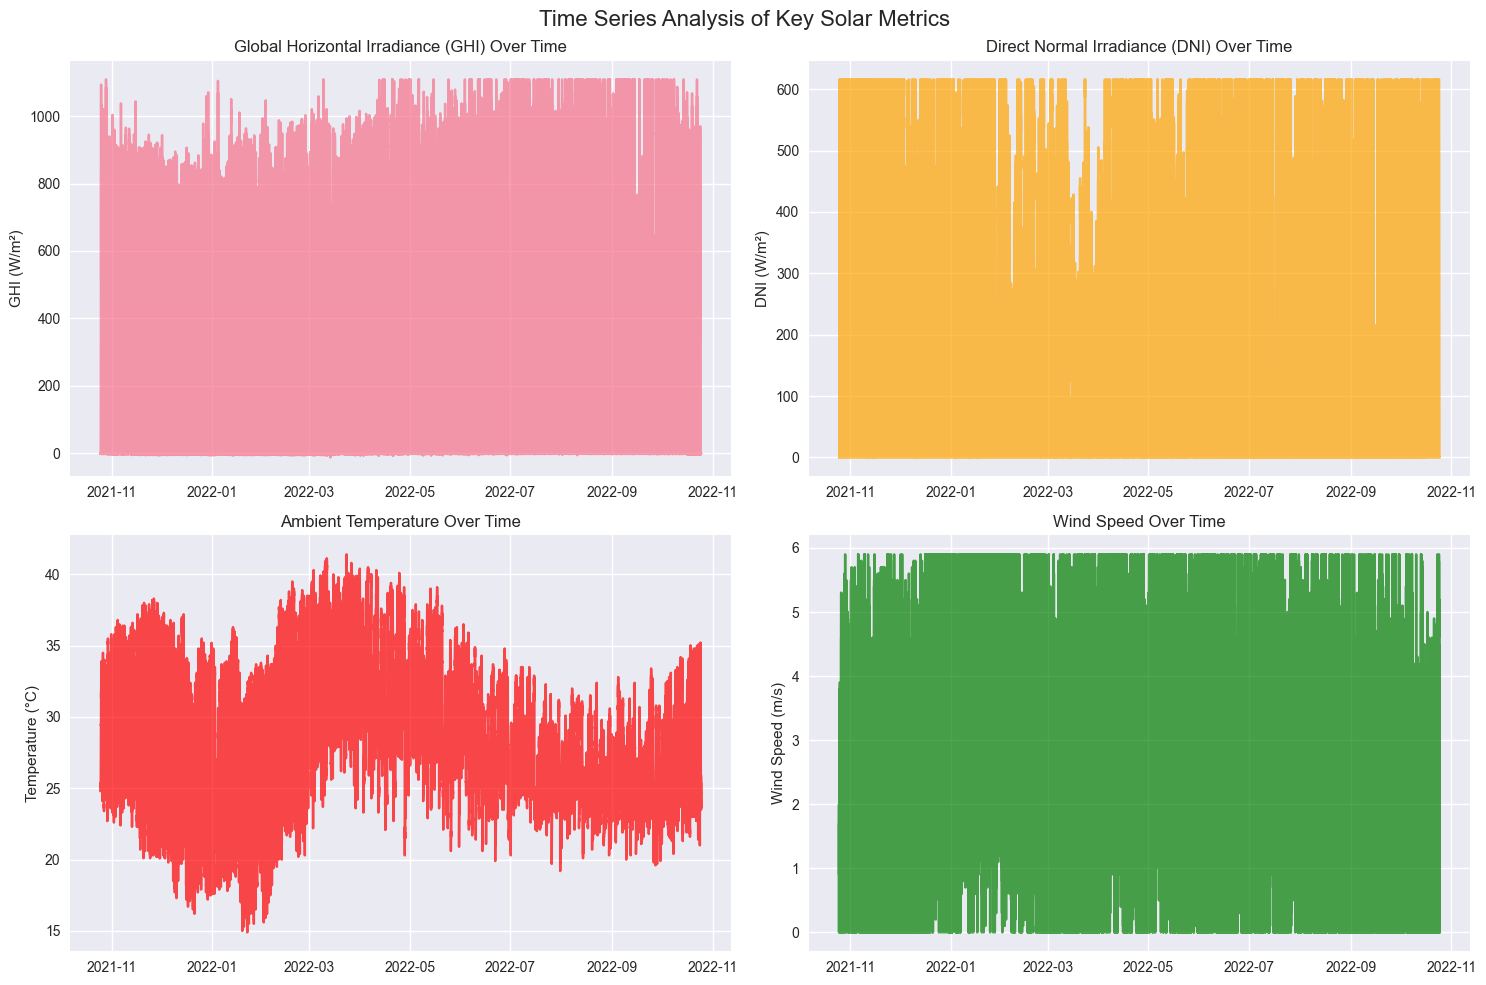

In [7]:
# ## 6. Time Series Analysis

# %%
# Convert timestamp to datetime
df_clean['Timestamp'] = pd.to_datetime(df_clean['Timestamp'])

# %%
# Set timestamp as index for time series analysis
df_clean.set_index('Timestamp', inplace=True)

# %%
# Plot key time series
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
fig.suptitle('Time Series Analysis of Key Solar Metrics', fontsize=16)

# GHI
axes[0,0].plot(df_clean['GHI'], alpha=0.7)
axes[0,0].set_title('Global Horizontal Irradiance (GHI) Over Time')
axes[0,0].set_ylabel('GHI (W/m²)')

# DNI
axes[0,1].plot(df_clean['DNI'], alpha=0.7, color='orange')
axes[0,1].set_title('Direct Normal Irradiance (DNI) Over Time')
axes[0,1].set_ylabel('DNI (W/m²)')

# Temperature
axes[1,0].plot(df_clean['Tamb'], alpha=0.7, color='red')
axes[1,0].set_title('Ambient Temperature Over Time')
axes[1,0].set_ylabel('Temperature (°C)')

# Wind Speed
axes[1,1].plot(df_clean['WS'], alpha=0.7, color='green')
axes[1,1].set_title('Wind Speed Over Time')
axes[1,1].set_ylabel('Wind Speed (m/s)')

plt.tight_layout()
plt.show()

In [ ]:
# ## 7. Cleaning Impact Analysis

# %%
# Compare module performance before and after cleaning
if 'Cleaning' in df_clean.columns:
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))
    
    # ModA comparison
    cleaning_effect_a = df_clean.groupby('Cleaning')['ModA'].mean()
    axes[0].bar(['No Cleaning', 'Cleaning'], cleaning_effect_a, color=['red', 'green'])
    axes[0].set_title('Average ModA - Cleaning Effect')
    axes[0].set_ylabel('ModA (W/m²)')
    
    # ModB comparison  
    cleaning_effect_b = df_clean.groupby('Cleaning')['ModB'].mean()
    axes[1].bar(['No Cleaning', 'Cleaning'], cleaning_effect_b, color=['red', 'green'])
    axes[1].set_title('Average ModB - Cleaning Effect')
    axes[1].set_ylabel('ModB (W/m²)')
    
    plt.tight_layout()
    plt.show()

In [ ]:
# ## 8. Correlation Analysis

# %%
# Select key numeric columns for correlation
corr_columns = ['GHI', 'DNI', 'DHI', 'TModA', 'TModB', 'Tamb', 'RH', 'WS', 'BP']
corr_data = df_clean[corr_columns]

# %%
# Correlation heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(corr_data.corr(), annot=True, cmap='coolwarm', center=0,
            square=True, fmt='.2f')
plt.title('Correlation Matrix of Solar Metrics')
plt.tight_layout()
plt.show()


In [ ]:
# ## 9. Scatter Plot Relationships

# %%
# Scatter plots to understand relationships
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# WS vs GHI
axes[0,0].scatter(df_clean['WS'], df_clean['GHI'], alpha=0.5)
axes[0,0].set_xlabel('Wind Speed (m/s)')
axes[0,0].set_ylabel('GHI (W/m²)')
axes[0,0].set_title('Wind Speed vs Solar Irradiance')

# RH vs Tamb
axes[0,1].scatter(df_clean['RH'], df_clean['Tamb'], alpha=0.5, color='orange')
axes[0,1].set_xlabel('Relative Humidity (%)')
axes[0,1].set_ylabel('Temperature (°C)')
axes[0,1].set_title('Humidity vs Temperature')

# RH vs GHI
axes[1,0].scatter(df_clean['RH'], df_clean['GHI'], alpha=0.5, color='green')
axes[1,0].set_xlabel('Relative Humidity (%)')
axes[1,0].set_ylabel('GHI (W/m²)')
axes[1,0].set_title('Humidity vs Solar Irradiance')

# Tamb vs GHI
axes[1,1].scatter(df_clean['Tamb'], df_clean['GHI'], alpha=0.5, color='red')
axes[1,1].set_xlabel('Temperature (°C)')
axes[1,1].set_ylabel('GHI (W/m²)')
axes[1,1].set_title('Temperature vs Solar Irradiance')

plt.tight_layout()
plt.show()

In [1]:
# ## 10. Distribution Analysis

# %%
# Histograms of key variables
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# GHI Distribution
axes[0,0].hist(df_clean['GHI'], bins=50, alpha=0.7, edgecolor='black')
axes[0,0].set_xlabel('GHI (W/m²)')
axes[0,0].set_ylabel('Frequency')
axes[0,0].set_title('Distribution of Global Horizontal Irradiance')

# Wind Speed Distribution
axes[0,1].hist(df_clean['WS'], bins=50, alpha=0.7, color='orange', edgecolor='black')
axes[0,1].set_xlabel('Wind Speed (m/s)')
axes[0,1].set_ylabel('Frequency')
axes[0,1].set_title('Distribution of Wind Speed')

# Temperature Distribution
axes[1,0].hist(df_clean['Tamb'], bins=50, alpha=0.7, color='red', edgecolor='black')
axes[1,0].set_xlabel('Temperature (°C)')
axes[1,0].set_ylabel('Frequency')
axes[1,0].set_title('Distribution of Ambient Temperature')

# Relative Humidity Distribution
axes[1,1].hist(df_clean['RH'], bins=50, alpha=0.7, color='green', edgecolor='black')
axes[1,1].set_xlabel('Relative Humidity (%)')
axes[1,1].set_ylabel('Frequency')
axes[1,1].set_title('Distribution of Relative Humidity')

plt.tight_layout()
plt.show()

NameError: name 'plt' is not defined

In [ ]:
# ## 11. Bubble Chart

# %%
# Bubble chart: GHI vs Tamb with bubble size = RH
plt.figure(figsize=(12, 8))
scatter = plt.scatter(df_clean['Tamb'], df_clean['GHI'], 
                     c=df_clean['RH'], s=df_clean['RH']/2, 
                     alpha=0.6, cmap='viridis')
plt.colorbar(scatter, label='Relative Humidity (%)')
plt.xlabel('Ambient Temperature (°C)')
plt.ylabel('GHI (W/m²)')
plt.title('GHI vs Temperature (Bubble size = Relative Humidity)')
plt.show()

In [15]:
# ## 12. Export Cleaned Data

# %%
# Export cleaned data (make sure data/ is in .gitignore!)
df_clean.reset_index(inplace=True)  # Reset index for export
df_clean.to_csv('../data/togo_clean.csv', index=False)
print("Cleaned data exported to ../data/togo_clean.csv")

Cleaned data exported to ../data/togo_clean.csv


In [ ]:
# ## 13. Key Insights Summary

# %%
print("=== KEY INSIGHTS ===")
print(f"1. Dataset size: {df.shape[0]:,} rows, {df.shape[1]} columns")
print(f"2. Missing values handled: {df.isnull().sum().sum()} total missing values")
print(f"3. Outliers detected: {df['has_outlier'].sum()} rows with extreme values")
print(f"4. Data ranges:")
print(f"   - GHI: {df_clean['GHI'].min():.1f} to {df_clean['GHI'].max():.1f} W/m²")
print(f"   - Temperature: {df_clean['Tamb'].min():.1f} to {df_clean['Tamb'].max():.1f} °C")
print(f"   - Wind Speed: {df_clean['WS'].min():.1f} to {df_clean['WS'].max():.1f} m/s")

# Check for strong correlations
corr_with_ghi = df_clean.corr()['GHI'].sort_values(ascending=False)
print(f"5. Top correlations with GHI:")
for i, (col, val) in enumerate(corr_with_ghi.head(4).items()):
    if col != 'GHI':
        print(f"   - {col}: {val:.3f}")